# Lab 5

## Author: Skorik Sergey

### Task 3
Consider the following bi-level optimization problem:



*   L_train = |h + w|^2
*   L_val = |w|^2

Run [DrMAD](https://arxiv.org/pdf/1601.00917.pdf) (hyperparameter optimization with trajectory linearization) and piecewise trajectory linearization modification. Visualize optimization trajectories in two surface plots: (h, w, L_train), (h, w, L_val).

### Theory

**DrMAD algorithm:**


1.   **inputs:** initial weights $w_0$, learned parameter $w_T$, hyperparameters $\boldsymbol{\lambda}$, weight decay $γ$, learning rate $α$
2.   initialize $d\boldsymbol{\lambda}$ $←$ 0, $d\boldsymbol{v}$ $←$ 0, $d\boldsymbol{w} ← ∇_{\boldsymbol{w}}l_{\text{valid}}$, $\beta_{T-1} ← 1 - \frac{1}{T}$
3.   **for** $t = T-1$ to $1$ **do**
4.   $\boldsymbol{w}_{t-1} ← (1 - \beta_{t})\boldsymbol{w}_{0} + \beta_{t}\boldsymbol{w}_{T}$ 
5.   $\beta_{t-1} ← \beta_{t} - \frac{1}{T}$
6.   $d\boldsymbol{v} ← d\boldsymbol{v} + \alpha d\boldsymbol{w}$
7.   $d\boldsymbol{\lambda} ← d\boldsymbol{\lambda} - (1 - \gamma) d\boldsymbol{v} ∇_{\boldsymbol{λ}}∇_{\boldsymbol{w}} l_{\text{train}}$
8.   **end for**
9.   **output:** gradient of $l_{valid}$ w.r.t. $\boldsymbol{λ}$,  $[w_0, w_1, \ldots, w_{T}]$

Learned parameters $w_T$ is obtained by $T$ steps of SGD with momentum ($l_{\text{train}}$ is a loss function). $l_{\text{train}}$ and $l_{valid}$ is defined above. 

So you need to do the following:

1. Initialize weights $w_0$ and hyperparameters $λ$. 
2. Obtain $w_T$ 
3. Optimize $λ$ and get optimization trajectories.
4.  Visualize optimization trajectories in two surface plots: (λ, w, L_train), (λ, w, L_val).

### Experiment

In [2]:
## JAX imports
import jax
import jax.numpy as jnp
from jax import random

## Utils functions
from matplotlib import pyplot as plt
import numpy as np

In [21]:
def l_train(w, h):
    return jnp.linalg.norm(h + w)**2

def l_valid(w):
    return jnp.linalg.norm(w)**2

def SGD_with_momentum(lr, w_decay, T, h, w_0):
    """
    Optimize weights by SGD with momentum

    Args:
        lr -- learning rate
        w_decay -- momentum
        T -- number of SGD steps
        h -- hyperparameters
        w_0 -- init weights
    """
    w_T = w_0
    v = 0
    for i in range(T):
        grads = jax.grad(lambda w: l_train(w, h))(w_T) 
        v = jax.tree_util.tree_map(lambda g: w_decay*v - (1 - w_decay)*g, grads)
        w_T = jax.tree_util.tree_map(lambda v_i: w_T + lr * v_i, v)
    return w_T


def DrMAD(w_0, w_T, h, w_decay, lr, T):
    # Check the theory for parameter explanation

    # Initialization
    w = [w_0]
    dh = 0
    dv = 0
    dw = jax.grad(lambda w: l_valid(w))
    dhdw = jax.jacrev(jax.grad(lambda w, h: l_train(w, h)))
    beta = 1 - 1/T
    for t in reversed(range(T-1)):
        w_t = (1 - beta) * w_0 + beta * w_T                                 # Step 4 
        beta = beta - 1 / T                                                 # Step 5
        dv = dv + lr * dw(w_t)                                              # Step 6
        dh = dh - (1-w_decay) * jnp.matmul(jnp.transpose(dv), dhdw(w_t, h)) # Step 7
        w.append(w_t)
    w.append(w_T)                                                           # optimization trajectory history
    dldh = jax.grad(lambda h: l_valid(h))(dh)                               # l_val wrt λ gradient

    return dldh, w

**weights optimization**

In [98]:
w_key = random.PRNGKey(0)
h_key = random.PRNGKey(1)
w_0 = random.normal(w_key, shape=(10,))
h = random.uniform(h_key, shape=(10,))
lr = 1e-2
w_decay = 0.5
T = 50
w_T = SGD_with_momentum(lr, w_decay, T, h, w_0)
print(f"Init L_train value: {l_train(w_0, h)}")
print(f"Optimized L_train value: {l_train(w_T, h)}")

Init L_train value: 3.146821975708008
Optimized L_train value: 0.41753432154655457


**hyperparameter optimization**

In [99]:
%%time
hyper_lr = 2e-2

h_hist = [h]
h_k = h
for k in range(5):
    dldh, w_history = DrMAD(w_0, w_T, h_k, w_decay, lr, T)
    h_k = h_k + lr * jax.grad(lambda w: l_valid(w))(w_T) * dldh
    h_hist.append(h_k)

CPU times: user 4.21 s, sys: 25.8 ms, total: 4.24 s
Wall time: 4.55 s


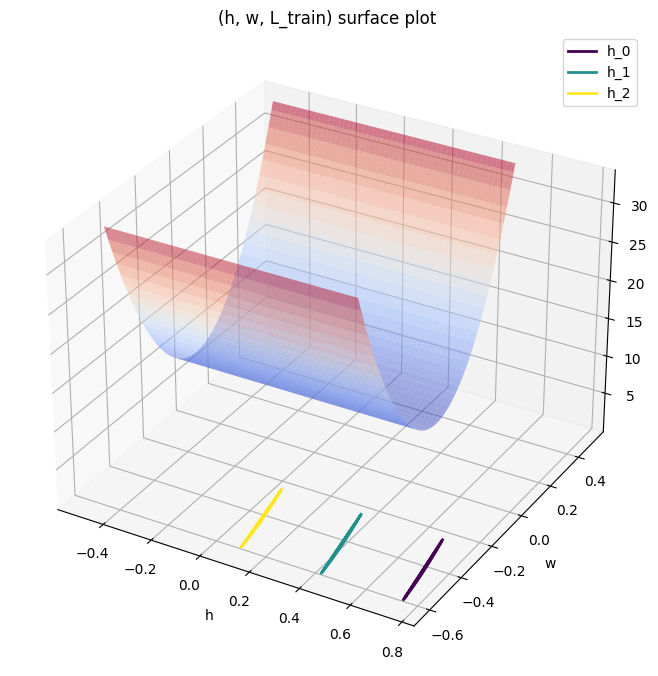

In [100]:
# Create a meshgrid for h and w
h_range = jnp.linspace(-0.5, 0.5, 100)
w_range = jnp.linspace(-0.5 , 0.5, 100)
H, W = jnp.meshgrid(h_range, w_range)

# Evaluate the objective function for L_train on the meshgrid
L_train_grid = jnp.array([l_train(w, h) for w in W for h in H]).reshape(100, 100)

# Evaluate the optimization trajectory for L_train
y_traj_train_eval = jnp.array(w_history)
x_traj_train_eval = jnp.repeat(jnp.array(h_hist[0])[:, np.newaxis], y_traj_train_eval.shape[0], axis=1).transpose()

L_train_traj_eval = jnp.array([l_train(w, h) for w, h in zip(y_traj_train_eval, x_traj_train_eval)])

x2_traj_train_eval = jnp.repeat(jnp.array(h_hist[1])[:, np.newaxis], y_traj_train_eval.shape[0], axis=1).transpose()
L2_train_traj_eval = jnp.array([l_train(w, h) for w, h in zip(y_traj_train_eval, x_traj_train_eval)])

x3_traj_train_eval = jnp.repeat(jnp.array(h_hist[2])[:, np.newaxis], y_traj_train_eval.shape[0], axis=1).transpose()
L3_train_traj_eval = jnp.array([l_train(w, h) for w, h in zip(y_traj_train_eval, x_traj_train_eval)])


# Plot the surface for L_train and its optimization trajectory
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(H, W, L_train_grid, cmap='coolwarm', alpha=0.5)
ax1.plot(x_traj_train_eval[:, 0], y_traj_train_eval[:, 0], L_train_traj_eval, color='#440154', linewidth=2, label=r'h_0')
ax1.plot(x2_traj_train_eval[:, 0], y_traj_train_eval[:, 0], L2_train_traj_eval, color='#21908C', linewidth=2, label=r'h_1')
ax1.plot(x3_traj_train_eval[:, 0], y_traj_train_eval[:, 0], L3_train_traj_eval, color='#FDE725', linewidth=2, label=r'h_2')
ax1.set_xlabel('h')
ax1.set_ylabel('w')
ax1.set_zlabel('L_train')
ax1.set_title("(h, w, L_train) surface plot")
ax1.legend()

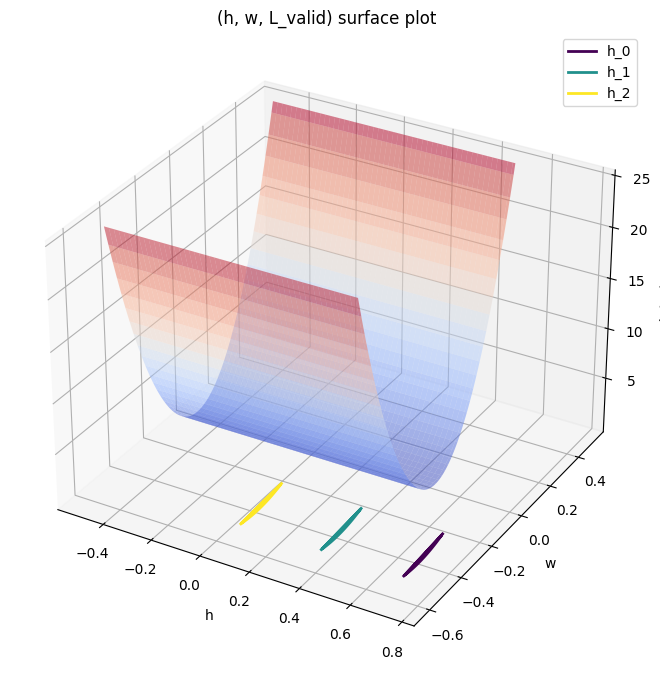

In [104]:
# Create a meshgrid for h and w
h_range = jnp.linspace(-0.5, 0.5, 100)
w_range = jnp.linspace(-0.5 , 0.5, 100)
H, W = jnp.meshgrid(h_range, w_range)

# Evaluate the objective function for L_train on the meshgrid
L_train_grid = jnp.array([l_valid(w) for w in W for h in H]).reshape(100, 100)

# Evaluate the optimization trajectory for L_train
y_traj_train_eval = jnp.array(w_history)
x_traj_train_eval = jnp.repeat(jnp.array(h_hist[0])[:, np.newaxis], y_traj_train_eval.shape[0], axis=1).transpose()

L_train_traj_eval = jnp.array([l_valid(w) for w, h in zip(y_traj_train_eval, x_traj_train_eval)])

x2_traj_train_eval = jnp.repeat(jnp.array(h_hist[1])[:, np.newaxis], y_traj_train_eval.shape[0], axis=1).transpose()
L2_train_traj_eval = jnp.array([l_valid(w) for w, h in zip(y_traj_train_eval, x_traj_train_eval)])

x3_traj_train_eval = jnp.repeat(jnp.array(h_hist[2])[:, np.newaxis], y_traj_train_eval.shape[0], axis=1).transpose()
L3_train_traj_eval = jnp.array([l_valid(w) for w, h in zip(y_traj_train_eval, x_traj_train_eval)])


# Plot the surface for L_train and its optimization trajectory
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(H, W, L_train_grid, cmap='coolwarm', alpha=0.5)
ax1.plot(x_traj_train_eval[:, 0], y_traj_train_eval[:, 0], L_train_traj_eval, color='#440154', linewidth=2, label=r'h_0')
ax1.plot(x2_traj_train_eval[:, 0], y_traj_train_eval[:, 0], L2_train_traj_eval, color='#21908C', linewidth=2, label=r'h_1')
ax1.plot(x3_traj_train_eval[:, 0], y_traj_train_eval[:, 0], L3_train_traj_eval, color='#FDE725', linewidth=2, label=r'h_2')
ax1.set_xlabel('h')
ax1.set_ylabel('w')
ax1.set_zlabel('L_train')
ax1.set_title("(h, w, L_valid) surface plot")
ax1.legend()

In [105]:
L_train = []
L_val = []
for h_k in h_hist:
    L_train.append(l_train(w_T, h_k))
    L_val.append(l_valid(w_T))

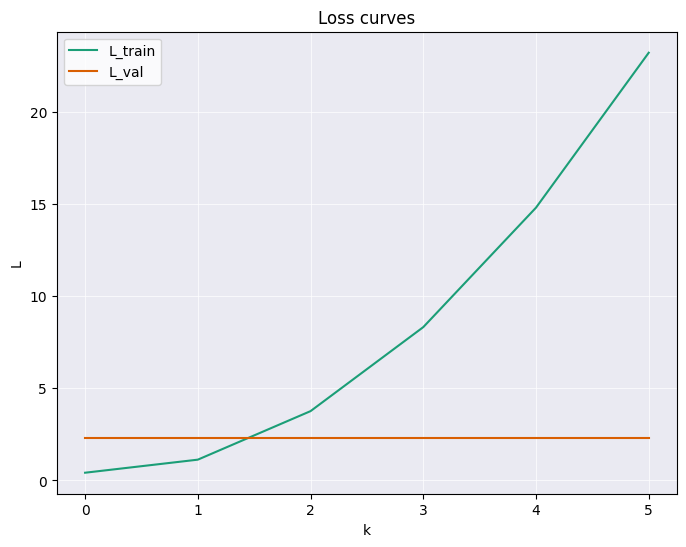

In [106]:
palette = plt.get_cmap('Dark2')
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor('#EAEAF2')

ax.plot(np.arange(len(L_train)), L_train, color=palette(0), label='L_train')
ax.plot(np.arange(len(L_val)), L_val, color=palette(1), label='L_val')

# Add grid lines to the plot
ax.grid(color='white', linestyle='-', linewidth=0.5)

# Set the axis labels and title
ax.set_xlabel('k')
ax.set_ylabel('L')
ax.set_title('Loss curves')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

### Conclusion

Можно заметить, что оптимизация гиперпараметров методом DrMAD дает только ухудшение на трейновом лоссе, потому что в коде сделано 1 неверное предположение. 

Алгоритм DrMAD выдает гиперградиет по валидационному лоссу, который от гиперпараметров не зависит. Таким образом, правильно было бы писать что такой градиент всегда равен нулю и в соответствии с шагом оптимизации 
$$ \boldsymbol{h}_{k+1} = \boldsymbol{h}_k + \boldsymbol{\eta}_h \cdot ∇_{\boldsymbol{w}}l_{valid} \cdot \frac{∂ \boldsymbol{w}_{T}}{∂\boldsymbol{h}} = \boldsymbol{h}_k + \boldsymbol{\eta}_h \cdot ∇_{\boldsymbol{w}}l_{valid} \cdot 0 = \boldsymbol{h}_k$$

гиперпараметры не менялись, а вся оптимизация делается на этапе алгоритма 1 при вычислении $\boldsymbol{w}_T$.

Возможно, я не правильно понял что должен выдавать алгоритм, либо можно поэксперементировать с другой валидационной функцией